# Importing Data

In [153]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import scipy 
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import datetime as dt
import yfinance as yf

In [154]:
us_data_path = '/Users/talhajamal/Documents/Documents/Imperial/Courses/Semester 2/Empirical Finance/IndividualProject/coursework_1/Data_coursework_1.xlsx'
us_data = pd.read_excel(us_data_path, sheet_name='US')
us_data['Date'] = pd.to_datetime(us_data['Date'], dayfirst=True)
#start_date = dt(1984, 1, 1)
#us_data = us_data[us_data['Date'] > start_date] # Last 40 years of data

In [155]:
# Summary Statistics for US Data
us_data["Simple Returns"] = us_data['Stock Index'].pct_change()
us_data["Log Returns"] = np.log(us_data['Stock Index'] / us_data['Stock Index'].shift(1))
us_data["ST Returns"] = us_data['Short-term Yield'].pct_change()
us_data["LT Returns"] = us_data['Long-term Yield'].pct_change()
us_data['xt_1'] = us_data['Long-term Yield'].shift(1) - us_data['Short-term Yield'].shift(1)
us_data.dropna(inplace=True)
us_data.reset_index(drop = True, inplace=True)
us_data.head()

,Date,Stock Index,Short-term Yield,Long-term Yield,Simple Returns,Log Returns,ST Returns,LT Returns,xt_1
0,1792-02-29,2.496140,4.198,4.198,0.062644,0.060760,0.061173,0.061173,0.0
1,1792-03-31,2.297596,4.940,4.940,-0.079541,-0.082882,0.176751,0.176751,0.0
2,1792-04-30,2.350072,5.143,5.143,0.022840,0.022583,0.041093,0.041093,0.0
3,1792-05-31,2.562141,4.557,4.557,0.090239,0.086397,-0.113941,-0.113941,0.0
4,1792-06-30,2.512370,4.675,4.675,-0.019426,-0.019617,0.025894,0.025894,0.0


# Expanding Window Regression

In [156]:
# Expanding Window Regression
exp_forecast_err = []
exp_prediction = []
exp_benchmark_pred = []
exp_actual = []

for end in range(120, len(us_data) - 1, 1): #2784

    xt_1 = us_data[['xt_1']][:end]
    yt = us_data[['Log Returns']][:end]
    
    exp_model = LinearRegression()
    exp_model.fit(xt_1, yt)
    
    xt_test = us_data[['xt_1']][end:end+1]
    
    prediction = exp_model.predict(xt_test)[0][0]
    exp_prediction.append(prediction)
    
    actual = us_data['Log Returns'].iloc[end]
    exp_actual.append(actual)
    
    error = abs(prediction - actual)

    exp_forecast_err.append(error)

    exp_bench_pred = prediction - (exp_model.coef_[0][0] * xt_test.iloc[-1][0])
    exp_benchmark_pred.append(exp_bench_pred)

mse_model = mean_squared_error(exp_actual, exp_prediction)
mse_benchmark = mean_squared_error(exp_actual, exp_benchmark_pred)

In [157]:
print(mse_model, mse_benchmark)
print("The out of sample R squared is: ", 1 - (mse_model/mse_benchmark))


0.001945448402323024 0.001939223704135139
The out of sample R squared is:  -0.0032098917595797527


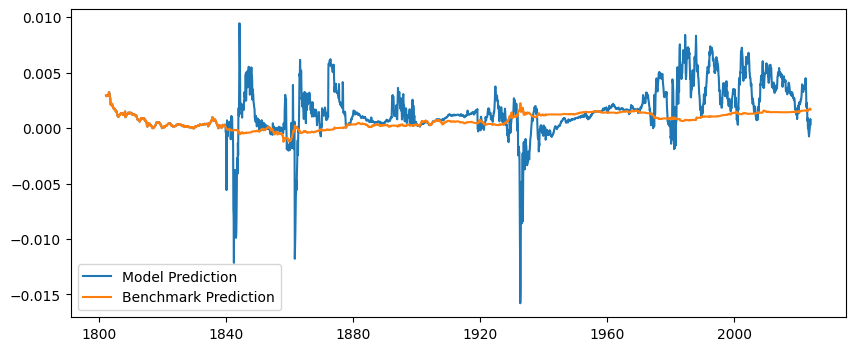

In [158]:
plt.figure(figsize=(10,4))
plt.plot(us_data['Date'][121:], exp_prediction, label = 'Model Prediction')
plt.plot(us_data['Date'][121:], exp_benchmark_pred, label = 'Benchmark Prediction')
plt.legend()

# Rolling Window Regression

In [159]:
# Rolling Window Regression
roll_prediction = []
roll_benchmark_pred = []
roll_actual = []

for end in range(120, len(us_data) - 1, 1): #2784

    start = end - 120

    xt_1 = us_data[['xt_1']][start:end]
    yt = us_data[['Log Returns']][start:end]
    
    roll_model = LinearRegression()
    roll_model.fit(xt_1, yt)
    
    xt_test = us_data[['xt_1']][end:end+1]
    
    prediction = exp_model.predict(xt_test)[0][0]
    roll_prediction.append(prediction)
    
    actual = us_data['Log Returns'].iloc[end+1]
    roll_actual.append(actual)
    

    roll_bench_pred = prediction - (roll_model.coef_[0][0] * xt_test.iloc[-1][0])
    roll_benchmark_pred.append(roll_bench_pred)

roll_mse_model = mean_squared_error(roll_actual, roll_prediction)
roll_mse_benchmark = mean_squared_error(roll_actual, roll_benchmark_pred)

In [160]:
print(roll_mse_model, roll_mse_benchmark)
print("The out of sample R squared is: ", 1 - (roll_mse_model/roll_mse_benchmark))

0.0019334599308398676 0.0021074209810090215
The out of sample R squared is:  0.08254689107530011


# Clark and West Test